In [41]:
import numpy as np
import pandas as pd
import thinkstats2
import thinkplot

import seaborn as sns
import matplotlib.pyplot as mth
import statsmodels.formula.api as smf

In [42]:
data = pd.read_csv('steam.csv')
data['rating_pct'] = np.round((100 * data.positive_ratings) / (data.positive_ratings + data.negative_ratings), 2)

In [43]:
data.head()

,appid,name,release_date,english,developer,publisher,platforms,required_age,categories,genres,steamspy_tags,achievements,positive_ratings,negative_ratings,average_playtime,median_playtime,owners,price,rating_pct
0,10,Counter-Strike,2000-11-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-P...,Action,Action;FPS;Multiplayer,0,124534,3339,17612,317,10000000-20000000,7.19,97.39
1,20,Team Fortress Classic,1999-04-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-P...,Action,Action;FPS;Multiplayer,0,3318,633,277,62,5000000-10000000,3.99,83.98
2,30,Day of Defeat,2003-05-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Valve Anti-Cheat enabled,Action,FPS;World War II;Multiplayer,0,3416,398,187,34,5000000-10000000,3.99,89.56
3,40,Deathmatch Classic,2001-06-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-P...,Action,Action;FPS;Multiplayer,0,1273,267,258,184,5000000-10000000,3.99,82.66
4,50,Half-Life: Opposing Force,1999-11-01,1,Gearbox Software,Valve,windows;mac;linux,0,Single-player;Multi-player;Valve Anti-Cheat en...,Action,FPS;Action;Sci-fi,0,5250,288,624,415,5000000-10000000,3.99,94.80


We will test a hyphotesis that a game with certain genre a greater mean of positive ratings than a mean of negative ratings.

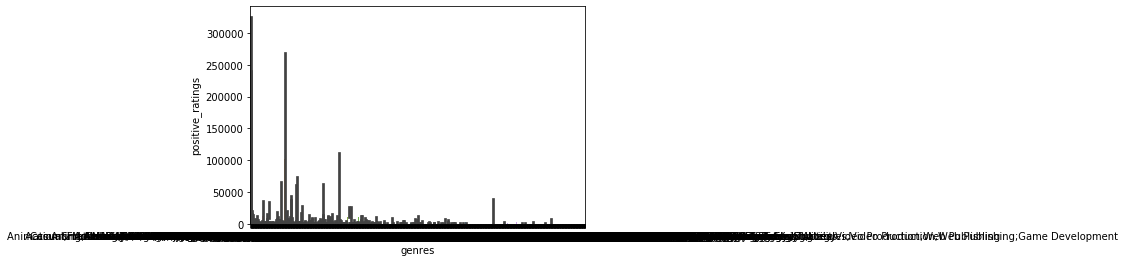

In [44]:
sns.barplot(x='genres',y='positive_ratings',data=data)


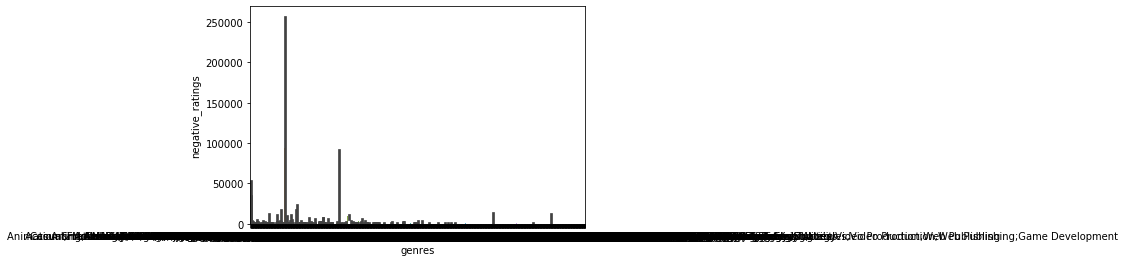

In [45]:
sns.barplot(x='genres',y='negative_ratings',data=data)

In [46]:
data[data.genres=='Action'].positive_ratings.std(), data[data.genres=='Action'].positive_ratings.mean()

(16368.69331633967, 3611.361803084223)

In [47]:
data[data.genres=='Action'].negative_ratings.std(), data[data.genres=='Action'].negative_ratings.mean()

(3181.0927994994636, 639.6714116251483)

We see that certain genres have more negative reviews and some have more positive reviews but that appears non-symmetric.

In [48]:
def SimulateSample(mu=3600, sigma=16500, n=9, iters=1000):
    xbars = []
    for j in range(iters):
        xs = np.random.normal(mu, sigma, n)
        xbar = np.mean(xs)
        xbars.append(xbar)
    return xbars

xbars = SimulateSample()

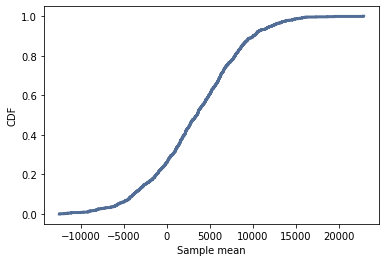

In [49]:
cdf = thinkstats2.Cdf(xbars)
thinkplot.Cdf(cdf)
thinkplot.Config(xlabel='Sample mean',
                 ylabel='CDF')

In [50]:
np.mean(xbars)

3334.567785618331

The value above is very close to the actual mean.

# Hypothesis testing

In [51]:
class DiffMeansPermute(thinkstats2.HypothesisTest):

    def TestStatistic(self, data):
        group1, group2 = data
        test_stat = abs(group1.mean() - group2.mean())
        return test_stat

    def MakeModel(self):
        group1, group2 = self.data
        self.n, self.m = len(group1), len(group2)
        self.pool = np.hstack((group1, group2))

    def RunModel(self):
        np.random.shuffle(self.pool)
        data = self.pool[:self.n], self.pool[self.n:]
        return data

In [53]:
data1 = data.positive_ratings.values, data.negative_ratings.values
data1

(array([124534,   3318,   3416, ...,      0,      2,      4], dtype=int64),
 array([3339,  633,  398, ...,    1,    0,    0], dtype=int64))

In [54]:
ht = DiffMeansPermute(data1)
pvalue = ht.PValue()
pvalue

0.0

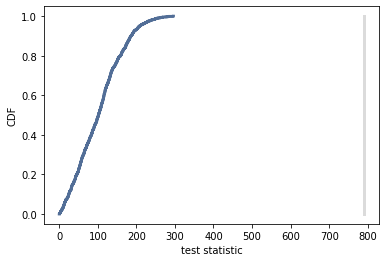

In [55]:
ht.PlotCdf()
thinkplot.Config(xlabel='test statistic',
                   ylabel='CDF')

The p-value is equal to zero, therefore we can reject the null hypothesis. The null hypothesis states that the mean of positive ratings of the action genre is equal to mean of its negative ratings. That means one of them is more than the other.

In [57]:
class DiffMeansOneSided(DiffMeansPermute):

    def TestStatistic(self, data):
        group1, group2 = data
        test_stat = group1.mean() - group2.mean()
        return test_stat

In [59]:
ht = DiffMeansOneSided(data1)
pvalue = ht.PValue()
pvalue

0.0

This function outputs the difference between two values; therefore the null hypothesis can be rejected completely.

# Chi-square test

In [61]:
class PregLengthTest(thinkstats2.HypothesisTest):

    def MakeModel(self):
        firsts, others = self.data
        self.n = len(firsts)
        self.pool = np.hstack((firsts, others))

        pmf = thinkstats2.Pmf(self.pool)
        self.values = range(35, 44)
        self.expected_probs = np.array(pmf.Probs(self.values))

    def RunModel(self):
        np.random.shuffle(self.pool)
        data = self.pool[:self.n], self.pool[self.n:]
        return data
    
    def TestStatistic(self, data):
        firsts, others = data
        stat = self.ChiSquared(firsts) + self.ChiSquared(others)
        return stat

    def ChiSquared(self, lengths):
        hist = thinkstats2.Hist(lengths)
        observed = np.array(hist.Freqs(self.values))
        expected = self.expected_probs * len(lengths)
        stat = sum((observed - expected)**2 / expected)
        return stat

In [64]:
ht = PregLengthTest(data1)
p_value = ht.PValue()
print('p-value =', p_value)
print('actual =', ht.actual)
print('ts max =', ht.MaxTestStat())

p-value = 0.0
actual = 51.24879924307121
ts max = 23.917384404764242


If we specifically test the deviations of first babies and others from the expected number of births in each week of pregnancy, the results are statistically significant with a very small p-value.  But at this point we have run so many tests, we should not be surprised to find at least one that seems significant.

In [ ]:
We tested the deviation of positiv